<a href="https://colab.research.google.com/github/brisabn/Tarefa2-MCF/blob/main/Tarefa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ≽^•༚• ྀི≼ Tarefa 2: Análise Espectral

Brisa do Nascimento Barbosa — Universidade Federal de Minas Gerais, 2024.

Jupyter Notebook criado pelo Google Colab.

## Upload dos arquivos de entrada

In [112]:
!git clone https://github.com/brisabn/Tarefa2-MCF.git
%cd Tarefa2-MCF
!ls

Cloning into 'Tarefa2-MCF'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 3.95 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Tarefa2-MCF/Tarefa2-MCF
dow2.txt  dow.txt  house.txt  piano.txt  README.md  Tarefa2.ipynb  trumpet.txt


# *°:⋆ₓₒ Transformadas de Fourier de formas de onda

Nesta seção, utilizamos a Transformada Rápida de Fourier (FFT) para recuperar o som de uma nota de piano e de trompete a partir de um arquivo que representa a forma de onda.



## Utilitários

### Extração de dados

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import Audio, display

sample_rate=44100 # taxa padrão da indústria

def load_data(filename):
    return np.loadtxt(filename, dtype=int)

### FFT para cálculo de magnitudes

**Transformada de Fourier:**
Dada uma função periódica $f(x)$ definida no intervalo $0 \leq x < L$, podemos escrevê-la como uma série de Fourier, na forma geral

$$f(x) = \sum_{k=0}^{\infty} \alpha_k \cos\left(\frac{2\pi kx}{L}\right) + \sum_{k=1}^{\infty} \beta_k \sin\left(\frac{2\pi kx}{L}\right)$$

Alternativamente, podemos usar $\cos(\theta) = \frac{1}{2}\left(e^{i\theta} + e^{-i\theta}\right)$ e $\sin(\theta) = \frac{1}{2}i\left(e^{i\theta} - e^{-i\theta}\right)$, de forma a obter

$$f(x) = \sum_{k=-\infty}^{\infty} \gamma_k e^{\frac{i 2\pi kx}{L}}$$, onde

$$\gamma_k =
\begin{cases}
\frac{1}{2}(a_k - i\beta_k) & \text{se } k < 0,\\
a_0 & \text{se } k = 0,\\
\frac{1}{2}(a_k + i\beta_k) & \text{se } k > 0.
\end{cases}$$

Fazendo as devidas manipulações matemática, os coeficientes de Fourier $\gamma_k$ podem ser expressos como

$$\gamma_k = \frac{1}{L} \int_{0}^{L} f(x) e^{-i \frac{2\pi kx}{L}} \, dx$$

**Transformada de Fourier Discreta (DFT)** é equivalente à Transformada de Fourier contínua para sinais conhecidos, mas é definida apenas em instantes separados por intervalos discretos de amostragem.

$$\gamma_k = \frac{1}{N} \sum_{n=0}^{N-1} y_n \exp\left(- i\frac{2\pi kn}{N}\right) .$$

Por convenção, ignoramos o fatos $\frac{1}{N}$ e representaremos os coeficientes de Fourier como $C_k$.

$$C_k = \sum_{n=0}^{N-1} y_n \exp\left(- i\frac{2\pi kn}{N}\right) .$$

$C_k$ define, na prática, os coeficientes de Fourier.

**Transformada Inversa de Fourier Discreta (IDFT)** é o complemento da DFT, assim, dados os coeficientes $C_k$, podemos recuperar exatamente os valores das amostras $y_n$ de onde vieram (exceto por erro de arredondamento).

$$ y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp\left(i \frac{2\pi kn}{N}\right)$$

Uma observação é que se duas funções têm os mesmos valores nos pontos de amostragem, suas Transformadas Discretas de Fourier (DFTs) serão idênticas. Para funções suavemente variáveis, sem mudanças abruptas entre amostras, conhecer apenas os valores nos pontos de amostra é suficiente para obter uma ideia geral da forma da função. Frequentemente, estamos interessados em funções representadas por conjuntos de amostras, não por funções contínuas, e a DFT é uma ferramenta excelente para esse tipo de dados.


**Transformada Rápida de Fourier (FFT)** A FFT é um algoritmo eficiente para calcular a DFT. Enquanto a DFT direta tem complexidade $ O(N^2) $, a FFT reduz essa complexidade para $ O(N \log N) $, tornando o cálculo muito mais rápido e viável para grandes conjuntos de dados. O algoritmo FFT utilizado pela biblioteca numpy é o Cooley-Tukey, o qual aplica divisão e conquista para resolver recursivamente. Dessa forma, aFFT combina esses resultados de maneira eficiente usando a simetria e periodicidade dos expoentes complexos.

O procedimento funciona da seguinte maneira:

O algoritmo divide a DFT de um sinal de comprimento $N$ em duas DFTs de comprimento $\frac{N}{2}$. Esta decomposição é feita repetidamente até que o comprimento do sinal seja reduzido a 1, onde a DFT pode ser calculada diretamente. Em seguida, o sinal original é dividido em duas subsequências, uma contendo os termos de índice par e a outra contendo os termos de índice ímpar. Isso é repetido recursivamente. Por fim, as DFTs das subsequências são então combinadas para obter a DFT do sinal original. Este passo envolve multiplicações complexas por expoentes do tipo $e^{-i \frac{2\pi kn}{N}}$, conhecidos como *twiddle factors*.

Matematicamente, a DFT de um sinal $x_n$ pode ser escrita como:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2\pi kn}{N}}
$$

Para aplicar o Algoritmo de Cooley-Tukey, o sinal é dividido em subsequências de índices pares e ímpares:

$$
X_k = \sum_{m=0}^{N/2-1} x_{2m} e^{-i \frac{2\pi k (2m)}{N}} + \sum_{m=0}^{N/2-1} x[2m+1] e^{-i \frac{2\pi k (2m+1)}{N}}
$$

Isso pode ser reescrito como:

$$
X_k = X_{k_{\text{par}}} + e^{-i \frac{2\pi k}{N}} X_{{\text{ímpar}}[k]}
$$

onde $X_{\text{par}}[k]$ e $X_{\text{ímpar}}[k]$são as DFTs das subsequências dos índices pares e ímpares, respectivamente.


In [114]:
def compute_fft(data):
    fft_data = np.fft.fft(data)
    magnitudes = np.abs(fft_data)
    return magnitudes

### Frequência da nota

Após calcular a FFT, obtemos as magnitudes das componentes de frequência do sinal. A frequência dominante em um sinal é identificada pelo índice do coeficiente de Fourier com a maior magnitude.
Assim, a frequência de pico é calculada utilizando a fórmula:
   $$ \text{peak_freq} = \frac{\text{peak_idx} \times \text{sample_rate}}{\text{data_tam}} $$
   onde:
   - `peak_idx`: Índice da maior magnitude em `magnitudes`.
   - `sample_rate`: Taxa de amostragem do sinal original.
   - `data_tam`: Número total de pontos de dados do sinal original.

A nota musical é determinada calculando a posição da frequência dominante na escala musical
padrão (onde a nota A4 tem frequência de 440 Hz) e calculamos a distância em semitons dessa nota para a nota cuja frequência foi identificada.

$$
\text{note_number} = 12 \times \log_2 \left( \frac{\text{freq}}{440} \right) + 49
$$



In [115]:
def find_peak_frequency(magnitudes, sample_rate, data_length):
    peak_index = np.argmax(magnitudes)
    peak_frequency = (peak_index * sample_rate) / data_length
    return peak_frequency

def frequency_to_note(freq):
    notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    note_num = round(12 * np.log2(freq / 440) + 49)
    n = (note_num - 1 ) % len(notes)
    octave = int((note_num + 8) / len(notes))
    return notes[n] + str(octave)

### Plotagem e áudio

In [116]:
def plot_waveform(data):
    plt.figure(figsize=(6, 4))
    plt.plot(data, color='rebeccapurple')
    plt.title('Forma de onda')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

def plot_magnitudes(magnitudes, num_coefficients=10000):
    plt.figure(figsize=(6, 4))
    plt.plot(magnitudes[:num_coefficients], color='slateblue')
    plt.title('Magnitudes dos primeiros 10.000 coeficientes da FFT')
    plt.xlabel('Coeficiente')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

In [117]:
def save_wav_and_display(data, sample_rate, wav_filename='output.wav'):
    normalized_data = data / np.max(np.abs(data))
    wav_data = np.int16(normalized_data * 32767)
    write(wav_filename, sample_rate, wav_data)
    display(Audio(wav_filename))

## Aplicação

### ♫ Piano

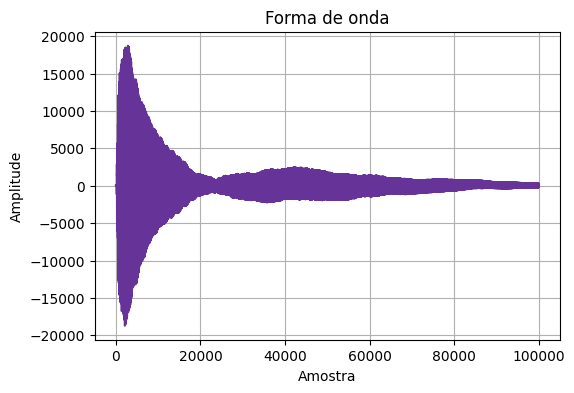

In [118]:
    data = load_data('/content/Tarefa2-MCF/piano.txt')
    plot_waveform(data)
    save_wav_and_display(data, sample_rate)

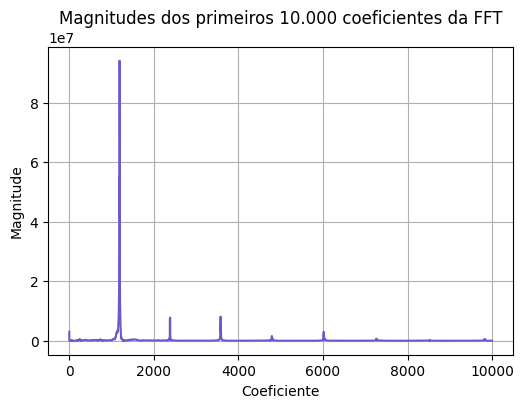

In [119]:
    magnitudes_piano = compute_fft(data)
    plot_magnitudes(magnitudes_piano)

In [120]:
    peak_freq_piano = find_peak_frequency(magnitudes_piano, sample_rate, len(data))
    note = frequency_to_note(peak_freq_piano)

    print(f"A frequência fundamental é {peak_freq_piano:.2f} Hz")
    print(f"A nota musical é {note}")

A frequência fundamental é 524.79 Hz
A nota musical é C5


### ♫ Trumpet

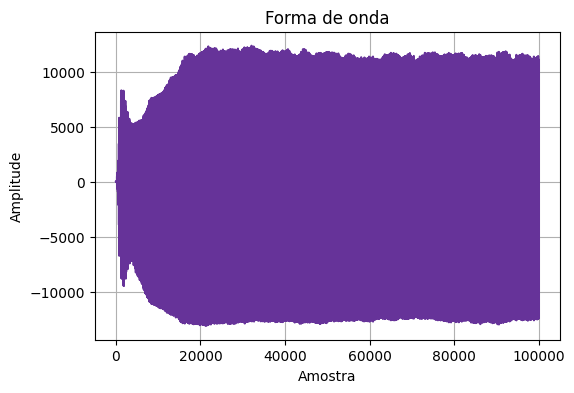

In [121]:
    data = load_data('/content/Tarefa2-MCF/trumpet.txt')
    plot_waveform(data)
    save_wav_and_display(data, sample_rate)

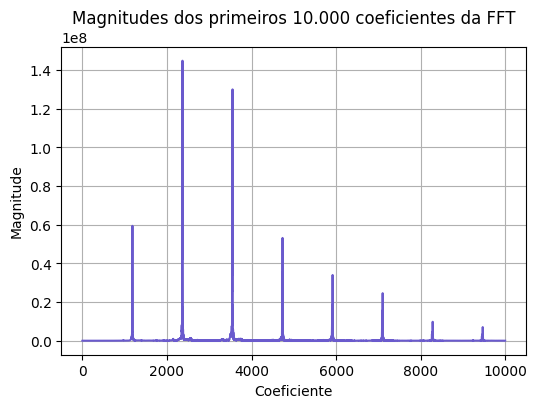

In [122]:
    magnitudes_trumpet = compute_fft(data)
    plot_magnitudes(magnitudes_trumpet)

In [123]:
    peak_freq_trumpet = find_peak_frequency(magnitudes_trumpet, sample_rate, len(data))
    note = frequency_to_note(peak_freq_trumpet)

    print(f"A frequência fundamental é {peak_freq_trumpet:.2f} Hz")
    print(f"A nota musical é {note}")

A frequência fundamental é 1043.85 Hz
A nota musical é C6


## Discussão de resultados

A forma da onda dos dois intrumentos apresenta um formato bem diferente, isso se dá pela diferença de timbre.

O gráfico do piano mostra um pico dominante na frequência fundamental, seguido por vários picos bem menoresque correspondem aos harmônicos. A presença de harmônicos, mas com menores intensidades, confere ao piano um som mais suave. Ou seja, após o "ataque" inicial, há um decaimento significativo.

Já o gráfico do trompete indica que seu timbre incisivo e sustentação mais longa. Ainda, além do pico na frequência fundamental, há vários outros picos significativos, de forma que o som aparenta mais potente.

# *°:⋆ₓₒ Filtragem e suavização de Fourier

Nesta seção, realizamos o carregamento de dados do índice Dow Jones, em seguida, aplicamos a Transformada Rápida de Fourier (FFT) e a Transformada do Cosseno Discreta (DCT) para filtrar e reconstruir os dados originais.

## Utilitários

### Extração de dados

In [124]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename):
    return np.loadtxt(filename, dtype=float)

def plot_data(data, period):
  plt.figure(figsize=(8, 4))
  plt.plot(data, label='Original', color='royalblue')
  title = 'Dow Jones Industrial Average'
  full_title = f'{title} ({period})'
  plt.title(full_title)
  plt.xlabel('Dia útil')
  plt.ylabel('Valor de fechamento')
  plt.grid(True)

## Filtragem de dados com FFT
Aqui, é feita a filtragem dos coeficientes da FFT realizada nos dados fornecidos, mantendo apenas uma porcentagem especificada dos coeficientes originais. Em seguida, ela reconstrói os dados filtrados de volta para o domínio temporal utilizando a Transformada Inversa de Fourier (IFFT) e retorna essa versão reconstruída dos dados.

In [125]:
def filter_fft_and_reconstruct(data, keep_percent):
    # Transformada Discreta de Fourier - DFT (b)
    fft_coefficients = np.fft.rfft(data)

    # Zerando elementos (c)
    num_coef = len(fft_coefficients)
    num_to_keep = int(num_coef * (keep_percent / 100)) # coeficientes a serem mantidos
    filtered_fft_coefficients = np.zeros_like(fft_coefficients) # array zerado
    filtered_fft_coefficients[:num_to_keep] = fft_coefficients[:num_to_keep] # adicionado os mantidos

    # Calcula Transformada Inversa de Fourier (d)
    reconstructed_data = np.fft.irfft(filtered_fft_coefficients, n=len(data))

    return reconstructed_data

### Aplicação com FFT

Aplicamos o código desenvolvido ao conjunto de dados "Dow Jones Industrial Average (2006 a 2010)", mantendo 10% e 2% da informação original.

Os gráficos gerados mostram que a curva reconstruída com 10% dos dados suavizou muito bem a curva original, preservando significativamente seu formato geral. Embora a reconstrução com apenas 2% dos dados tenha sido menos precisa, nota-se que mesmo com 98% dos dados descartados, ainda assim a curva resultante manteve uma suavização aceitável.







**Mantendo os primeiros 10%**

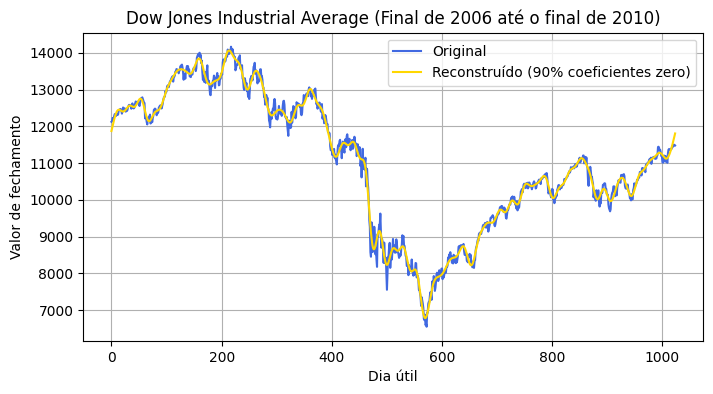

In [126]:
data = load_data('/content/Tarefa2-MCF/dow.txt')
plot_data(data, 'Final de 2006 até o final de 2010')

# Plotar os dados reconstruídos com 10% dos coeficientes
reconstructed_data = filter_fft_and_reconstruct(data, 10)
plt.plot(reconstructed_data, label='Reconstruído (90% coeficientes zero)', color='gold')
plt.legend()
plt.show()

**Comparação mantendo 2% e os 10% primeiros na filtragem**

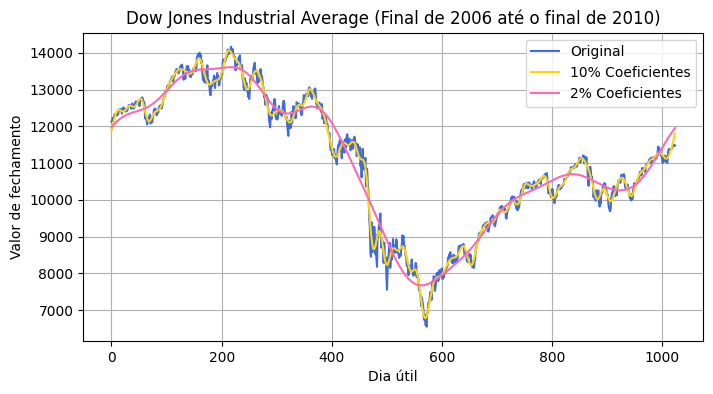

In [127]:
data = load_data('/content/Tarefa2-MCF/dow.txt')
plot_data(data, 'Final de 2006 até o final de 2010')

# Plotar os dados reconstruídos com 10% dos coeficientes
reconstructed_data = filter_fft_and_reconstruct(data, 10)
plt.plot(reconstructed_data, label='10% Coeficientes', color='gold')

# Plotar os dados reconstruídos com 2% dos coeficientes
reconstructed_data = filter_fft_and_reconstruct(data, 2)
plt.plot(reconstructed_data, label='2% Coeficientes', color='hotpink')

plt.legend()
plt.show()

## Filtragem de dados usando DCT
A FFT é um algoritmo amplamente usado que calcula a Transformada de Fourier Discreta (DFT) de maneira eficiente. Ela captura tanto a amplitude quanto a informação de fase, Por outro lado, a DCT foca em representar sinais de valor real usando apenas funções cosseno, resultando em uma saída de valor real. Isso torna a DCT particularmente vantajosa para aplicações como compressão de imagens, onde captura eficientemente o sinal com menos coeficientes. No entanto, ela é menos flexível que a FFT, visto que  projetada especificamente para dados de valores reais. Ainda, ela pode não ser tão eficaz onde a informação de fase é crucial, já que não preserva detalhes de fase como a FFT.

Em especial, o uso da DCT em vez da FFT apresenta diferentes vantagem no caso de conjuntos de dados que não são periódicas. De fato, a maioria dos conjuntos de dados não são periódicos, no entando , podemos transformar qualquer função em um intervalo finito em uma função periódica simplesmente repetindo-a infinitamente. Também podemos transformar qualquer função em uma função periódica simétrica adicionando a ela uma imagem espelhada de si mesma e então repetindo todo o processo infinitamente.

**Transformada de Cosseno Discreta (DCT)**

$c_k = y_0 + y_{\frac{N}{2}}\cos\left(\frac{2\pi k\frac{N}{2}}{N}\right) + 2 \sum_{n=1}^{\frac{N}{2}-1} y_n \cos\left(\frac{2\pi kn}{N}\right)$

**Transformada de Cosseno Discreta Inversa (IDCT)**

$y_n = \frac{1}{N} \left( c_0 + c_{\frac{N}{2}} \cos\left(\frac{2\pi i \frac{N}{2}}{N}\right) + 2 \sum_{k=1}^{\frac{N}{2}-1} c_k \cos\left(\frac{2\pi ki}{N}\right) \right)$

The indices of both samples and Fourier coefficients run from 0 to 1/2 N, so that there are 1/2 N + 1 of each in total: the DCT takes 1/2 N + 1 real numbers and transforms them into !N + 1 real coefficients (and the inverse OCT does the reverse). Indeed, the forward and reverse transforms in this case are actually the same mathematical expression, except for the leading factor of 1/ N in the IDCT.
Thus, one sometimes says that this transform is its own inverse (except for the factor 1/N).

**Caso do Type II**

The sample points are in the middle of the sample intervals rather than at their ends. In that case
symmetry about the midpoint of the interval implies that $y_n = y_{N-1-n}$ and making use once more of the fact that N is even, Eq. (7.15) becomes

**Transformada de Cosseno Discreta (DCT)**

$$ a_k = \sum_{n=0}^{N-1} y_n \cos\left(\frac{\pi k\left(n + \frac{1}{2}\right)}{N}\right)$$

**Transformada de Cosseno Discreta Inversa (IDCT)**

$$y_n = \frac{1}{N} \left[ a_0 + 2\sum_{k=1}^{N-1} a_k \cos\left(\frac{\pi k\left(n - \frac{1}{2}\right)}{N}\right) \right]$$

A transformada do cosseno, diferente da DFT, não assume que as amostras sejam periódicas. Ao espelhar a função transformada, a primeira e a última amostras não precisam ter o mesmo valor. Tornar uma função periódica pode criar descontinuidades problemáticas para as DFTs, mas a transformada discreta cosseno evita esses problemas e é preferível para dados não periódicos.

In [128]:
#   dct(y): Type-II discrete cosine transform (DCT) of real data y
#   idct(a): Type-II inverse DCT of a

# Written by Mark Newman <mejn@umich.edu>, June 24, 2011
# You may use, share, or modify this file freely

from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

# 1D DCT Type-II
def dct(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[:N] = y[:]
    y2[N:] = y[::-1]

    c = rfft(y2)
    phi = exp(-1j*pi*arange(N)/(2*N))
    return real(phi*c[:N])

# 1D inverse DCT Type-II
def idct(a):
    N = len(a)
    c = empty(N+1,complex)

    phi = exp(1j*pi*arange(N)/(2*N))
    c[:N] = phi*a
    c[N] = 0.0
    return irfft(c)[:N]

In [129]:
def filter_dct_and_reconstruct(data, keep_percent):
    # Transformada Discreta de Cosseno - DCT (g)
    dct_coefficients = dct(data)

    # Zerando elementos
    num_coef = len(dct_coefficients)
    num_to_keep = int(num_coef * (keep_percent / 100)) # coeficientes a serem mantidos
    filtered_dct_coefficients = np.zeros_like(dct_coefficients)
    filtered_dct_coefficients[:num_to_keep] = dct_coefficients[:num_to_keep]

    # Calcula Transformada Inversa de Cosseno (IDCT)
    reconstructed_data = idct(filtered_dct_coefficients)

    return reconstructed_data

### Aplicação com DCT

Observa-se que, ao utilizar a Transformada de Fourier Discreta (DFT), ocorrem imprecisões nos extremos do sinal, pois os valores tendem a se ajustar de modo que a função se torne periódica. Em contraste, com a Transformada Cosseno Discreta (DCT), esse problema não ocorre, resultando em uma melhor suavização dos dados.

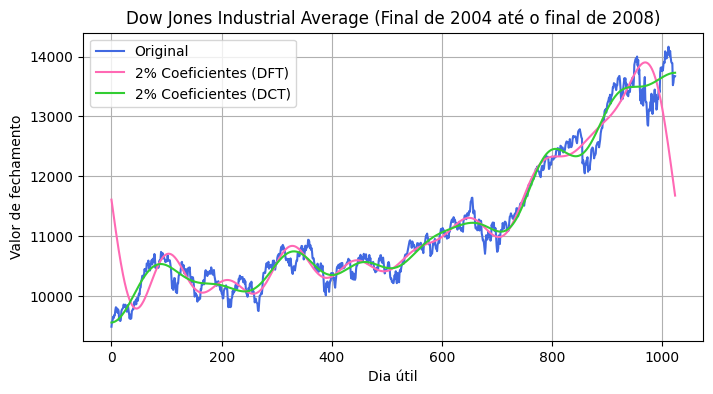

In [130]:
data = load_data('/content/Tarefa2-MCF/dow2.txt')
plot_data(data, 'Final de 2004 até o final de 2008')

# Plotar os dados reconstruídos com 2% dos coeficientes
reconstructed_data_dft = filter_fft_and_reconstruct(data, 2)
plt.plot(reconstructed_data_dft, label='2% Coeficientes (DFT)', color='hotpink')

# Plotar os dados reconstruídos com 2% dos coeficientes
reconstructed_data_dct = filter_dct_and_reconstruct(data, 2)
plt.plot(reconstructed_data_dct, label='2% Coeficientes (DCT)', color='limegreen')

plt.legend()
plt.show()

## Discussão de resultados

# *°:⋆ₓₒ Compressão de imagem

Nesta seção, realiza-se a compressão de imagem utilizando a Transformada Cosseno Discreta (DCT). Este é, vagamente, o método de compressão utilizado pelo formato JPEG, utilizado para reduzir o tamanho de arquivos de imagens digitais sem comprometer significativamente a qualidade visual.

## Utilitários

### Extração de dados
Para extrair e visualizar uma imagem a partir de um arquivo de dados, carregamos os inteiros contidos no arquivo, que representam os valores de intensidade dos pixels da imagem. Esses números são organizados em uma matriz bidimensional, onde cada elemento da matriz corresponde a um pixel da imagem.

In [131]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename):
    return np.loadtxt(filename, dtype=int)

def plot_original(data_array):
    plt.imshow(data_array, cmap='gray')
    plt.colorbar()
    plt.title('original image')
    plt.show()

### Transformação Discreta de Cosseno 2D
Usaremos o seguinte bloco de código que implementa a função DCT e sua inversa, a qual foi explica na seção 2 "Filtragem e suavização de Fourier". Ainda, no caso da aplicação em imagens, realizamos a two-dimensional Type-II DCT, que form the mathematical basis for the computer image file JPEG.

A DCT bidimensional, por outro lado, é aplicada a uma matriz bidimensional, ou seja, a uma imagem ou um bloco de dados com duas dimensões. A principal diferença entre a DCT 1D e a DCT 2D é que a DCT 2D aplica a transformação em ambas as dimensões do dado.

Para aplicar a DCT 2D, realiza-se a DCT 1D em cada linha da matriz, seguida da DCT 1D em cada coluna da matriz resultante. Essa aplicação sequencial em duas dimensões transforma a matriz original em uma nova matriz, onde as componentes de frequência estão mais concentradas, facilitando operações como compressão. Similarmente, a inversa aplica-se em duas dimensões para transformar os dados do domínio da frequência de volta ao domínio espacial ou do tempo.


The JPEG format works by dividing the pixels in an image into blocks, performing OCTs on the blocks (two-dimensional Type-II OCTs to be exact), then looking for coefficients ak that are small and can be discarded.4 The remaining coefficients are stored in a file and, when you view a picture or request the relevant web page, your computer reconstitutes the picture using the inverse transform of Eq. (7.35)

The advantage of storing images this way is that in many cases most of the ak are very small and can be neglected. Because only the small remaining fraction of the Fourier
coefficients need to be stored, the size of the file required to store the whole picture is thus greatly reduced, and if the picture is transmitted over the Internet, for instance as part of a web page, we save on the time needed to transmit it. The disadvantage is that, because some of the Fourier data are thrown away, the picture you get back on your screen isn't quite the same picture you started with.


In [132]:
#   dct(y): Type-II discrete cosine transform (DCT) of real data y
#   idct(a): Type-II inverse DCT of a
#   dct2(y): 2D DCT of 2D real array y
#   idct2(a): 2D inverse DCT real array a

# Written by Mark Newman <mejn@umich.edu>, June 24, 2011
# You may use, share, or modify this file freely

from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

# 1D DCT Type-II
def dct(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[:N] = y[:]
    y2[N:] = y[::-1]

    c = rfft(y2)
    phi = exp(-1j*pi*arange(N)/(2*N))
    return real(phi*c[:N])

# 2D DCT
def dct2(y):
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dct(y[i,:])
    for j in range(N):
        b[:,j] = dct(a[:,j])

    return b

# 1D inverse DCT Type-II
def idct(a):
    N = len(a)
    c = empty(N+1,complex)

    phi = exp(1j*pi*arange(N)/(2*N))
    c[:N] = phi*a
    c[N] = 0.0
    return irfft(c)[:N]

# 2D inverse DCT
def idct2(b):
    M = b.shape[0]
    N = b.shape[1]
    a = empty([M,N],float)
    y = empty([M,N],float)

    for i in range(M):
        a[i,:] = idct(b[i,:])
    for j in range(N):
        y[:,j] = idct(a[:,j])

    return y

## Compressão da imagem

### Coeficientes de Fourier

A seguinte função realiza DCT em duas dimensões. Ela itera sobre uma matriz de imagens em blocos de 16 x 16 pixels, aplicando a transformação para gerar uma matriz 16x16 de coeficientes de Fourier reais para cada bloco.

In [133]:
def process_dct(data_array):
  height, width = data_array.shape
  coef_array = np.zeros_like(data_array)

  block_tam = 16
  for i in range(0, height, block_tam):
      for j in range(0, width, block_tam):
          block = data_array[i:i+block_tam, j:j+block_tam]
          dct2_block = dct2(block)
          coef_array[i:i+block_tam, j:j+block_tam] = dct2_block

  return coef_array

### Threshold dos coeficientes de Fourier

Agora, com a matriz dos coeficientes de Fourier, define-se como zero os coeficientes cujo valor absoluto é menor que o limiar, realizando assim a compressão por limiarização. Isso significa que coeficientes de alta frequência (menos importantes para a representação visual) são removidos ou reduzidos a zero, o que pode reduzir significativamente o tamanho do arquivo de imagem comprimido.

Para calcular a taxa de compressão entre a imagem original e a imagem comprimida, é então calculada a razão entre o tamanho total da imagem original e o número de pixels não nulos na imagem comprimida. Isso fornece uma medida de quanto a imagem foi comprimida em relação ao tamanho original, sendo que uma relação maior indica uma maior compressão,


In [134]:
def process_dct_thresh(coef_array, threshold):
  coef_array[np.abs(coef_array) < threshold] = 0
  return coef_array

def calc_compression(original_img, compressed_img):
    total_orig = original_img.size
    nonzero_comp = original_img.size - np.count_nonzero(compressed_img == 0)
    compression_ratio = total_orig / nonzero_comp
    return compression_ratio

### Recuperação da imagem

Para recuperar a imagem original, é aplicado o processo inverso à transformação que comprimiu os dados. Isso permite restaurar os detalhes visuais presentes em cada bloco de 16x16 pixels, o que permite restaurar os detalhes visuais da imagem original.

In [135]:
def inverse_dct_to_image(thresh_data):
    height, width = thresh_data.shape
    reconstruct_array = np.zeros_like(data_array)

    block_tam = 16
    for i in range(0, height, block_tam):
        for j in range(0, width, block_tam):
            block = thresh_data[i:i+block_tam, j:j+block_tam]
            block_idct = idct2(block)
            reconstruct_array[i:i+block_tam, j:j+block_tam] = block_idct

    return reconstruct_array

### Gráfico de densidade da imagem

 Para visualizar a densidade da imagem, um histograma que mostra a distribuição das intensidades de pixel na imagem reconstruída. Cada barra no histograma representa a frequência ou a densidade de pixels que possuem uma determinada intensidade, permitindo uma visualização rápida e quantitativa das características de intensidade da imagem após o processo de reconstrução.

In [136]:
def plot_density(original_image, reconstructed_image):
    # Plotar gráfico de densidade e imagem reconstruída
    plt.figure(figsize=(6, 2))
    plt.hist(reconstructed_image.flatten(), bins=50, density=True, alpha=0.4, color='deeppink', label='Reconstructed Image')
    plt.hist(original_image.flatten(), bins=50, density=True, alpha=0.4, color='mediumseagreen', label='Original Image')
    plt.title('density')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.legend()

    plt.show()

## Plotagens



In [137]:
def plot_dct_image(coef_image, subplot_num):
    plt.subplot(subplot_num)
    im = plt.imshow(coef_image, cmap='gray', interpolation='nearest')
    plt.title('Fourier coefficients using DCT2')
    plt.colorbar(im, shrink=0.8)

def plot_thresholded_image(thresh_image, subplot_num):
    plt.subplot(subplot_num)
    im = plt.imshow(thresh_image, cmap='gray', interpolation='nearest')
    plt.title('Thresholded dct coefficients')
    plt.colorbar(im, shrink=0.8)

def plot_comparison(original_image, reconstructed_image):
  plt.figure(figsize=(10, 6))

  plt.subplot(1, 2, 1)
  plt.imshow(data_array, cmap='gray')
  plt.title('original image')

  plt.subplot(1, 2, 2)
  plt.imshow(reconstructed_image, cmap='gray')
  plt.title('reconstructed image')
  plt.show()

## Aplicação

**🏠Caso base com threshold = 10**

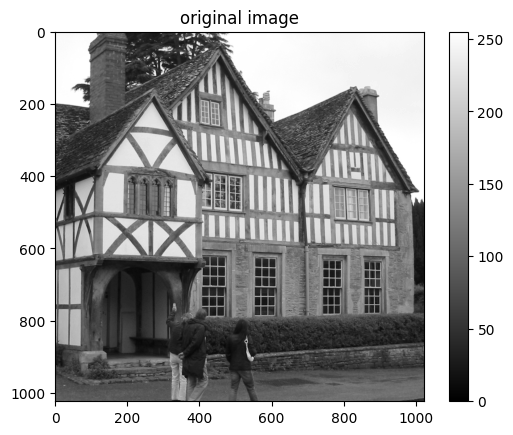

In [138]:
threshold = 10

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)

plt.imshow(data_array, cmap='gray')
plt.colorbar()
plt.title('original image')
plt.show()

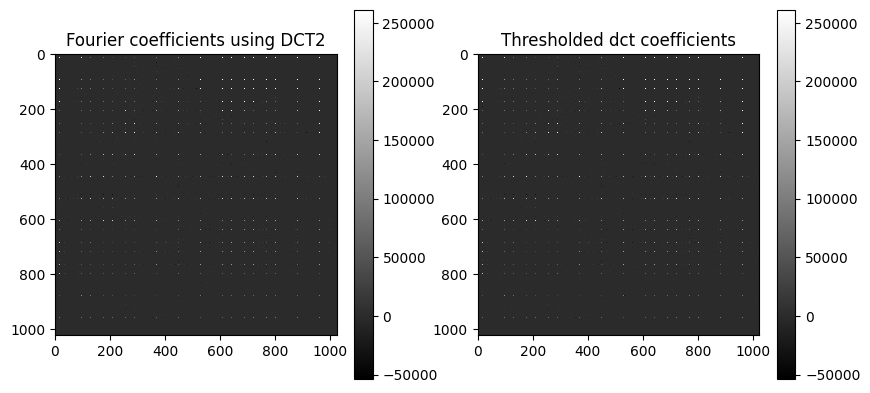

In [139]:
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)

plt.figure(figsize=(10, 6))

plot_dct_image(coef_image, 121)
plot_thresholded_image(thresh_image, 122)

plt.show()

1.3634018473828742


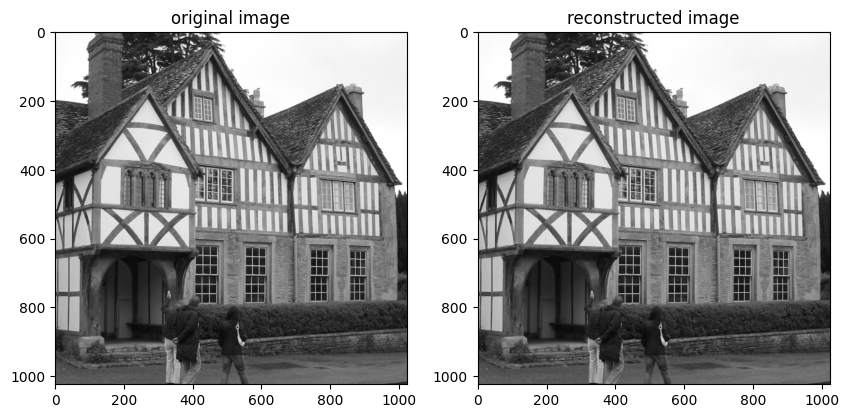

In [140]:
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)

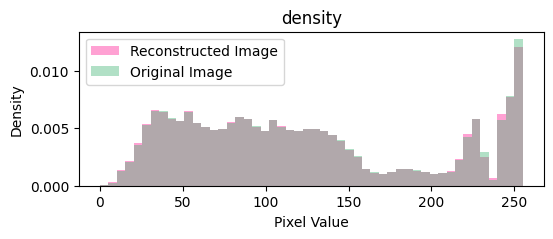

In [141]:
plot_density(data_array, reconstructed_image)

**🏠Caso 1: Threshold = 100**

2.980441647551724


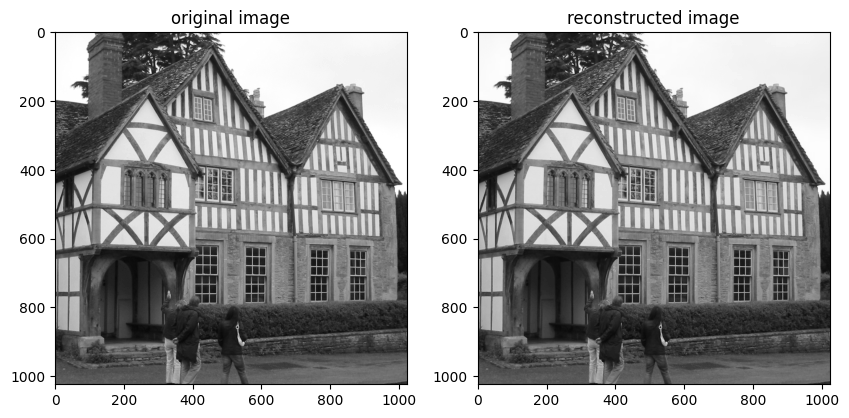

In [142]:
threshold = 100

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)


**🏠Caso 2: Threshold = 250**

5.582550271254479


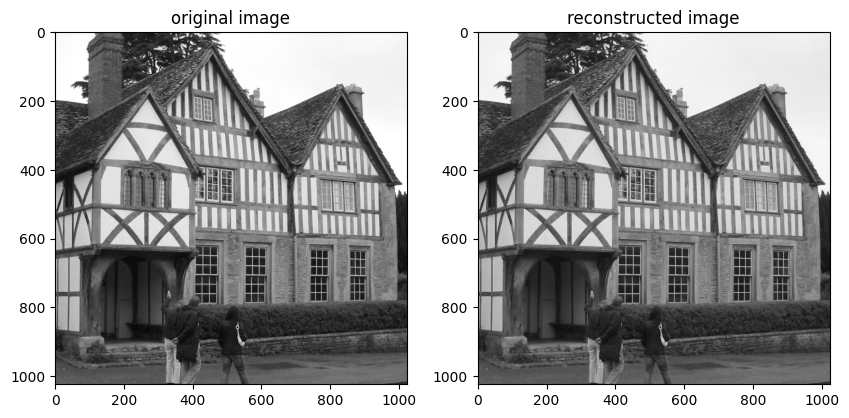

In [143]:
threshold = 250

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)


**🏠Caso 3: Threshold = 500**

9.918895142600388


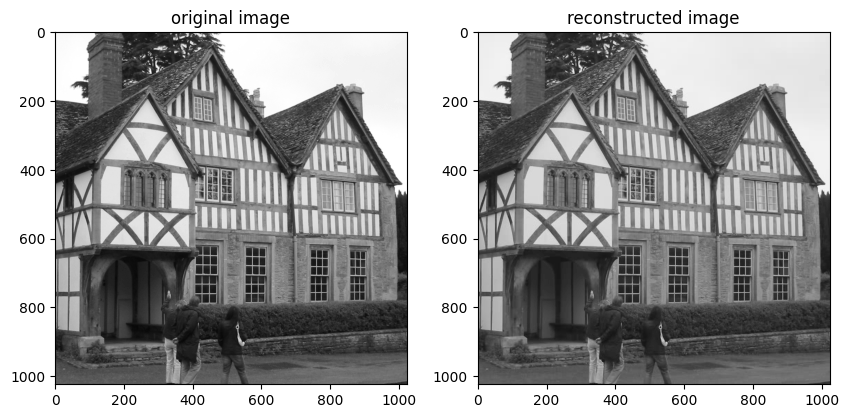

In [144]:
threshold = 500

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)


**🏠Caso 4: Threshold = 1000**

18.256424542099033


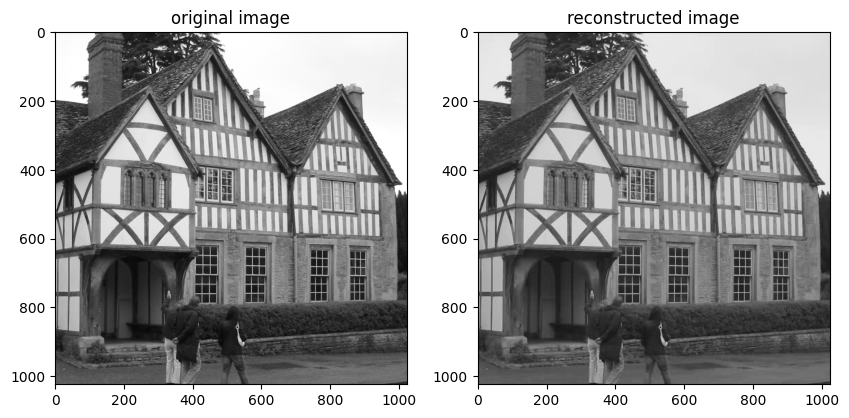

In [145]:
threshold = 1000

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)

**🏠Caso 5: Threshold = 5000**

80.87743925954493


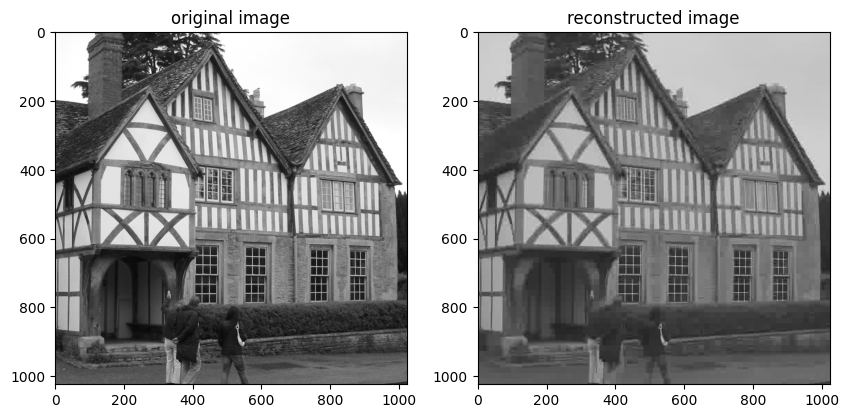

In [146]:
threshold = 5000

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)

**🏠Caso 5: Threshold = 25000**

234.58076062639822


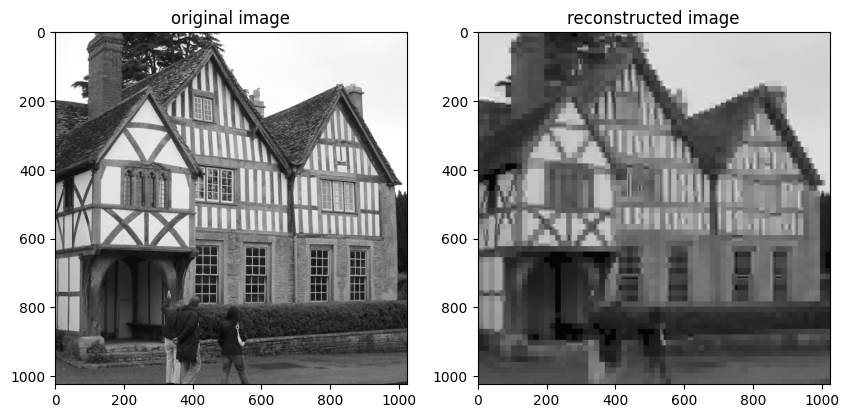

In [147]:
threshold = 25000

filename = '/content/Tarefa2-MCF/house.txt'
data_array = load_data(filename)
coef_image = process_dct(data_array)
thresh_image = process_dct_thresh(coef_image, threshold)
compression_ratio = calc_compression(data_array, thresh_image)
reconstructed_image = inverse_dct_to_image(thresh_image)

print(compression_ratio)
plot_comparison(data_array, reconstructed_image)

## Discussão de resultados

A partir dos testes realizados com diferentes níveis de compressão de imagem, foi possível observar como a taxa de compressão afeta significativamente a qualidade visual das imagens. Inicialmente, com um threshold de até 1000, as imagens mantinham sua forma e características principais, sendo praticamente indistinguíveis da imagem original. A única diferença notável era uma leve diminuição na luminosidade, mas os detalhes principais permaneciam intactos. No entanto, ao aumentar o threshold para 5000, notou-se uma deterioração mais evidente na qualidade visual. As cores se tornaram mais acinzentadas e os detalhes finos, como os casacos das pessoas em fotos, começaram a perder definição, resultando em uma imagem que não era tão parecida com a original. Com um threshold muito mais alto, de 25000, a qualidade da imagem caiu drasticamente, com as formas das pessoas com detalhes totalmente perdidos e uma resolução muitíssimo baixa.

# Referências

* https://web.mit.edu/~gari/teaching/6.555/lectures/ch_DFT.pdf
* https://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf
* https://howthefouriertransformworks.com/
* https://www.mindspore.cn/news/newschildren/en?id=2992&type=technologyBlog
* Newman, M. E. J. (2013). Computational physics (2nd ed.). CreateSpace Independent Publishing Platform.